In [126]:
import pandas as pd
import numpy as np
from scipy import stats
import sys
import matplotlib.pyplot as plt
from dateutil.parser import parse
import parse as str_parse
from intersection_proximity import intersection_proximity
from importlib import reload
from scipy.spatial import distance
from mpl_toolkits.mplot3d import Axes3D
from sklearn.neighbors import KNeighborsRegressor
from sklearn import preprocessing
from sklearn.linear_model import SGDRegressor
import seaborn as sns

users = pd.read_csv('ml-users.csv') 
%matplotlib notebook

In [2]:
crop_rows = -1

In [3]:
df_interactions = pd.read_csv('ml-interactions.tar.gz', compression='gzip')

if crop_rows > 0:
    df_interactions = df_interactions.head(crop_rows)

isna_result = pd.isna(df_interactions['action'])
df_interactions= df_interactions[~isna_result]
isna_result = pd.isna(df_interactions['action'])
assert sum(df_interactions['action'].isna()) == 0

df_interactions.rename(columns = {'ml-interactions.csv':'timestamp'}, inplace = True)

In [4]:
point_labels = pd.read_csv('sidewalk-seattle-label_point.csv')
point_labels.set_index('label_id', inplace=True)

In [5]:
label_correctness = pd.read_csv('ml-label-correctness.csv')

In [6]:
labeling_cols = ['user_id', 'audit_task_id', 'temporary_label_id']

In [7]:
label_correctness.set_index(labeling_cols, inplace=True)

In [8]:
# TODO: figure out why there are duplicates
label_correctness = label_correctness[~label_correctness.index.duplicated()]

In [9]:
label_correctness = label_correctness[~label_correctness['correct'].isna()]

In [10]:
df_interactions.set_index(labeling_cols, inplace=True)

In [11]:
df_interactions.reset_index(inplace=True)

In [12]:
# # fill nan temporary label id's
# df_interactions['temporary_label_id'] = df_interactions['temporary_label_id'].fillna(method='bfill')

# # get rid of nan label id's
# df_interactions = df_interactions[~pd.isna(df_interactions['temporary_label_id'])]

In [13]:
labels = df_interactions[df_interactions['action'] == 'LabelingCanvas_FinishLabeling']

In [14]:
labels.reset_index( inplace=True)

In [15]:
labels['audit_task_id'] = labels['audit_task_id'].astype(int)

/Users/neil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [16]:
labels['temporary_label_id'] = labels['temporary_label_id'].astype(int)

/Users/neil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [17]:
labels.set_index(labeling_cols, inplace=True)

In [18]:
labels_joined = label_correctness.join(labels, how='inner')

In [19]:
labels_joined.drop(['action', 'audit_task_interaction_id', 'timestamp', 'mission_id', 'lat', 'lng'], axis=1, inplace=True)

In [20]:
def parse_note(x):
    result = str_parse.parse('labelType:{},canvasX:{},canvasY:{}', x)
    return pd.Series({
        'labelType': result[0],
        'canvasX': result[1],
        'canvasY': result[2]
    })
    
labels_joined = labels_joined.join(labels_joined['note'].apply(parse_note))

In [21]:
labels_joined.drop('note', inplace=True, axis=1)

In [22]:
labels_joined['correct'] = labels_joined['correct'] == 't'

In [23]:
labels_joined.reset_index(inplace=True)

In [24]:
labels_joined.set_index('label_id', inplace=True)

In [25]:
labels_joined = labels_joined.join(point_labels[['sv_image_x', 'sv_image_y', 'lat', 'lng']], how='inner')

In [440]:
# curb_ramp = labels_joined[labels_joined['labelType'] == 'CurbRamp']

In [441]:
# X = curb_ramp[['canvasX', 'canvasY', 'pitch']].values

In [442]:
# y = curb_ramp['correct'].values

In [443]:
# X = X.astype(int)

In [448]:
# plt.figure()
# plt.scatter(X[:, 1], X[:, 2], c=y)

In [445]:
# clf = SGDRegressor()

In [446]:
# clf.fit(X, y)

In [447]:
# y_pred = clf.predict(X)

In [449]:
# plt.figure()
# plt.scatter(X[:, 1], X[:, 2], c=y_pred)

In [450]:
# fig, ax = plt.subplots()
# ax = plt.axes(projection='3d')

# xline = X[:, 0]
# yline = X[:, 1]
# zline = X[:, 2]

# ax.set_xlabel('Dimension 0')
# ax.set_ylabel('Dimension 1')
# ax.set_zlabel('Dimension 2')
# ax.scatter3D(xline, yline, zline, c=y_pred)

In [26]:
def dist_prox(row):
    try:
        ip = intersection_proximity.compute_proximity(row.lat, row.lng)
        return pd.Series({
            'distance': ip[0],
            'percent': ip[1]
        })
    except Exception:
        return pd.Series({
            'distance': -1,
            'percent': -1
        })

In [27]:
labels_joined = labels_joined.join(labels_joined.apply(dist_prox, axis=1))

In [28]:
def dist_to_street(row):
    try:
        return pd.Series({
            'dist_to_street': intersection_proximity.compute_dist_to_street(row.lat, row.lng)
        })
    except Exception:
        return pd.Series({
            'dist_to_street': -1
        })

In [29]:
labels_joined = labels_joined.join(labels_joined.apply(dist_to_street, axis=1))

In [30]:
le = preprocessing.LabelEncoder()
# transform label_type into an int
labels_joined['label_type'] = le.fit_transform(labels_joined['labelType'])

In [32]:
# # OR one-hot encoding
# oh = preprocessing.OneHotEncoder(handle_unknown='ignore')
# one_hot_label = oh.fit_transform(labels_joined['labelType'].values.reshape(-1, 1)).todense()

In [31]:
# fetch census tract data
# takes about 0.8s per request

import requests                                                                                                                                                                                             
import json                                                                                                                                                                                                 

def fetch_census_data(lng, lat):                                                                                                                                                                            
    geocode_url = 'https://geomap.ffiec.gov/FFIECGeocMap/GeocodeMap1.aspx/GetGeocodeData'                                                                                                                   
    census_url = 'https://geomap.ffiec.gov/FFIECGeocMap/GeocodeMap1.aspx/GetCensusData'                                                                                                                     
    data = {'sSingleLine': '-122.34080895597496, 47.608319043773058', 'iCensusYear': '2017'}                                                                                                                
    headers = {'Accept': 'application/json, text/javascript, */*; q=0.01', 'Content-Type': 'application/json; charset=utf-8'}                                                                               
    r = requests.post(geocode_url, data=json.dumps(data), headers=headers)                                                                                                                                  
    j = json.loads(r.content)                                                                                                                                                                               
    r2 = requests.post(census_url, data=json.dumps({'sMSACode': j['d']['sMSACode'], 'sStateCode': j['d']['sStateCode'], 'sCountyCode': j['d']['sCountyCode'], 'sTractCode': j['d']['sTractCode'], 'iCensusYear': j['d']['iCensusYear']}), headers=headers)                                                                                                                                                                                                 
    j2 = json.loads(r2.content)                                                                                                                                                                              
    return pd.Series(j2['d'])  


In [32]:
%%time
census_tract_data = labels_joined.apply(lambda x: fetch_census_data(x['lng'], x['lat']), axis=1)

CPU times: user 3min 34s, sys: 13.4 s, total: 3min 47s
Wall time: 1h 59min 50s


In [33]:
labels_joined.head()

,user_id,audit_task_id,temporary_label_id,correct,index,gsv_panorama_id,heading,pitch,zoom,labelType,canvasX,canvasY,sv_image_x,sv_image_y,lat,lng,distance,percent,dist_to_street,label_type
label_id,,,,,,,,,,,,,,,,,,,,
10407,0e1ae564-6d72-4670-98e4-71369cc5ab26,3366,5,True,18364631,L7SZej2SoaWbaqWE5bdB3Q,163.000000,-35.0000,1.0,NoCurbRamp,642,226,7629,-934,47.673359,-122.401878,10.140893,12.776624,4.897178,1
10409,0e1ae564-6d72-4670-98e4-71369cc5ab26,3367,7,False,18368154,KR-t1fL7CYXLuiwOpovEow,246.437500,-29.5625,1.0,NoCurbRamp,490,294,10007,-1294,47.672207,-122.401894,7.524051,22.726504,4.664472,1
10412,0e1ae564-6d72-4670-98e4-71369cc5ab26,3368,3,True,18372571,FDr1tDKldYX_PRQYQG713A,282.375000,-28.2500,1.0,SurfaceProblem,484,167,11160,-580,47.678715,-122.398766,31.683946,47.728451,1.872057,3
10413,0e1ae564-6d72-4670-98e4-71369cc5ab26,3368,4,False,18372984,EfYgFxuE0WkXVYEo0DJRsg,282.187500,-29.9375,1.0,SurfaceProblem,490,147,11177,-508,47.678722,-122.398911,43.905207,66.138486,2.937464,3
10429,0e1ae564-6d72-4670-98e4-71369cc5ab26,3378,20,True,18386753,-8GxPT6Z3OKYFimrUcYi1A,39.032169,-35.0000,1.0,CurbRamp,426,206,1897,-1076,47.687786,-122.402542,1.137692,15.489896,8.363878,0


In [460]:
labels_joined.shape

(5406, 20)

# Classification

In [438]:
features = ['pitch', 'label_type', 'canvasX', 'canvasY', 'distance', 'percent', 'dist_to_street', 'sv_image_x', 'sv_image_y']

In [439]:
# X = labels_joined[['pitch', 'label_type', 'canvasX', 'canvasY', 'distance', 'percent']].values
X = labels_joined[features].values
y = labels_joined['correct'].astype(int).values
label_id = labels_joined.index.values
label_type = labels_joined['labelType'].values

In [345]:
# # only select a certain type
# mask = (label_type=='NoCurbRamp')
# X = X[mask]
# y = y[mask]
# label_id = label_id[mask]
# label_type = label_type[mask]

In [346]:
# X = np.concatenate((X, one_hot_label), axis=1)

In [347]:
# # Undersample the majority class
# incorrect_indices, = np.where(y == 0)
# correct_indices, = np.where(y == 1)
# needed = min(len(incorrect_indices), len(correct_indices))
# chosen_indices = np.concatenate((np.random.choice(correct_indices, needed, replace=False), np.random.choice(incorrect_indices, needed, replace=False)))

# X = X[chosen_indices]
# y = y[chosen_indices]

In [348]:
# label_type = label_type[chosen_indices]

In [43]:
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegressionCV
# from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.ensemble import BalancedRandomForestClassifier, EasyEnsembleClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import svm

Using TensorFlow backend.


In [441]:
cutoff_invalid = 0.8
cutoff_valid = 0.8

In [ ]:
total = 0
predicted = 0
tp = 0
tn = 0
fp = 0
fn = 0
counter = 0
correct_prob = np.zeros(y.shape[0])
for train_index, test_index in KFold(n_splits=5, shuffle=True, random_state=0).split(X):
    counter += 1

    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
#     sampler = RandomUnderSampler(random_state=0)
#     sampler = RandomOverSampler(random_state=0)
#     X_resampled, y_resampled = sampler.fit_resample(X_train, y_train)
    X_resampled, y_resampled = X_train, y_train 
#     X_resampled, y_resampled = sampler.fit_resample(X_train, y_train)
    
    clf = RandomForestClassifier(n_jobs=-1, random_state=0, n_estimators=1000)
#     clf = BalancedRandomForestClassifier(n_jobs=-1, random_state=0, n_estimators=1000)
#     clf = BaggingClassifier(random_state=0)
#     clf = LogisticRegressionCV(n_jobs=-1, random_state=0, cv=5, max_iter=500)
#     clf = DecisionTreeClassifier(random_state=0)
#     clf = MLPClassifier(random_state=0, verbose=True)
    clf.fit(X_resampled, y_resampled)
    
#     neigh = KNeighborsClassifier(n_neighbors=n_neighbors)
    
#     with open("tree.txt", "w") as f:
#         f = export_graphviz(clf, out_file=f)
    use_probabilities = False
    
    if use_probabilities:
        prediction = clf.predict_proba(X_test)
    else:
        p = clf.predict(X_test)
        prediction = np.concatenate([1-p, p]).reshape((y_test.shape[0], 2))
        
    correct_prob[test_index] = prediction[:, 1]
    pred_neg = prediction[:, 0] > cutoff_invalid
    pred_pos = prediction[:, 1] > cutoff_valid

    tn_ = np.sum(y_test[pred_neg] == 0)
    fn_ = np.sum(pred_neg) - tn_
    tp_ = np.sum(y_test[pred_pos] == 1)
    fp_ = np.sum(pred_pos) - tp_


#     print('tn: ' + str(label_id[test_index][pred_neg & (y_test == 0)]))
#     print('fn: ' + str(label_id[test_index][pred_neg & (y_test == 1)]))
    
    print(f'tn: {tn_}, tp: {tp_}, fn: {fn_}, fp: {fp_}')
    
    predicted += (tn_ + fn_ + tp_ + fp_)
    tn += tn_
    fn += fn_
    tp += tp_
    fp += fp_
    
    total += y_test.shape[0]

In [443]:
# plt.figure()
# plt.ylabel('importance')
# plt.title('Feature Importances')
# plt.bar(features, clf.feature_importances_)
# locs, labels = plt.xticks()
# _ = plt.setp(labels, rotation=45)

In [444]:
accuracy = (tp + tn) / predicted
print(f'precision:\t{100*accuracy:.2f}%')
print(f'recall:\t\t{100*tn/(tn+fp):.2f}%')
print(f'predicted:\t{100*predicted/total:.2f}%')
print(f'tp / tp + fp:\t{100*tp/(tp+fp):.2f}%')
print(f'tn / tn + fn:\t{100*tn/(tn+fn):.2f}%')

precision:	50.22%
recall:		49.69%
predicted:	100.00%
tp / tp + fp:	81.84%
tn / tn + fn:	18.18%


0.5022197558268591

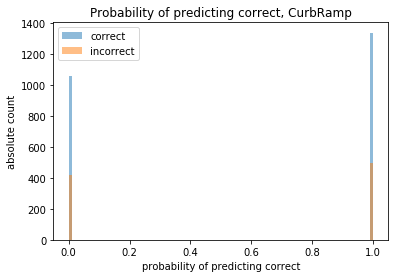

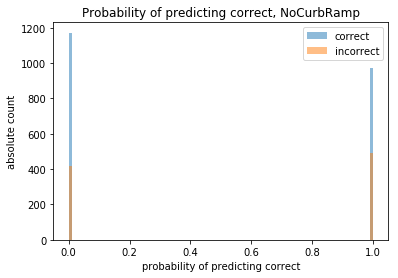

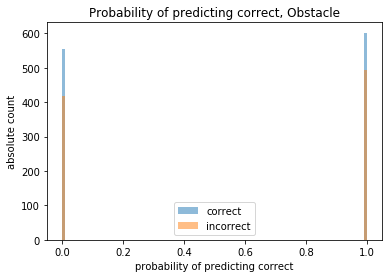

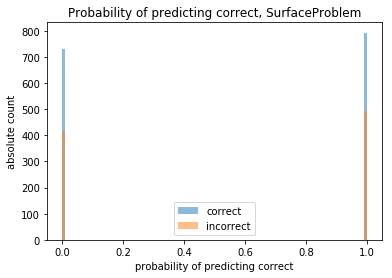

In [187]:
for chosen_type in np.unique(label_type):
    fig = plt.figure()
    plt.title(f'Probability of predicting correct, {chosen_type}')
    plt.hist(correct_prob[y==1 & (label_type == chosen_type)], bins=100, alpha=0.5, label='correct')
    plt.hist(correct_prob[y==0 & (label_type == chosen_type)], bins=100, alpha=0.5, label='incorrect')
    plt.xlabel('probability of predicting correct')
    plt.ylabel('absolute count')
    plt.legend()

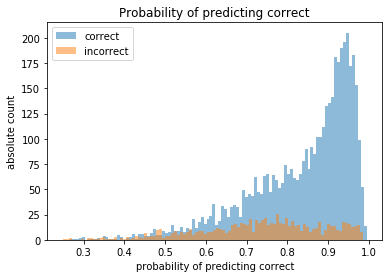

In [164]:
fig = plt.figure()
plt.title(f'Probability of predicting correct')
plt.hist(correct_prob[y==1], bins=100, alpha=0.5, label='correct')
plt.hist(correct_prob[y==0], bins=100, alpha=0.5, label='incorrect')
plt.xlabel('probability of predicting correct')
plt.ylabel('absolute count')
plt.legend()

## Classifying correctness based on lat/lng

In [37]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [38]:
vals = pd.DataFrame([labels_joined['lat'], labels_joined['lng'], labels_joined['correct']]).T

In [39]:
vals = vals[(vals['lat'] > 47) & (vals['lat'] < 48)]

<IPython.core.display.Javascript object>


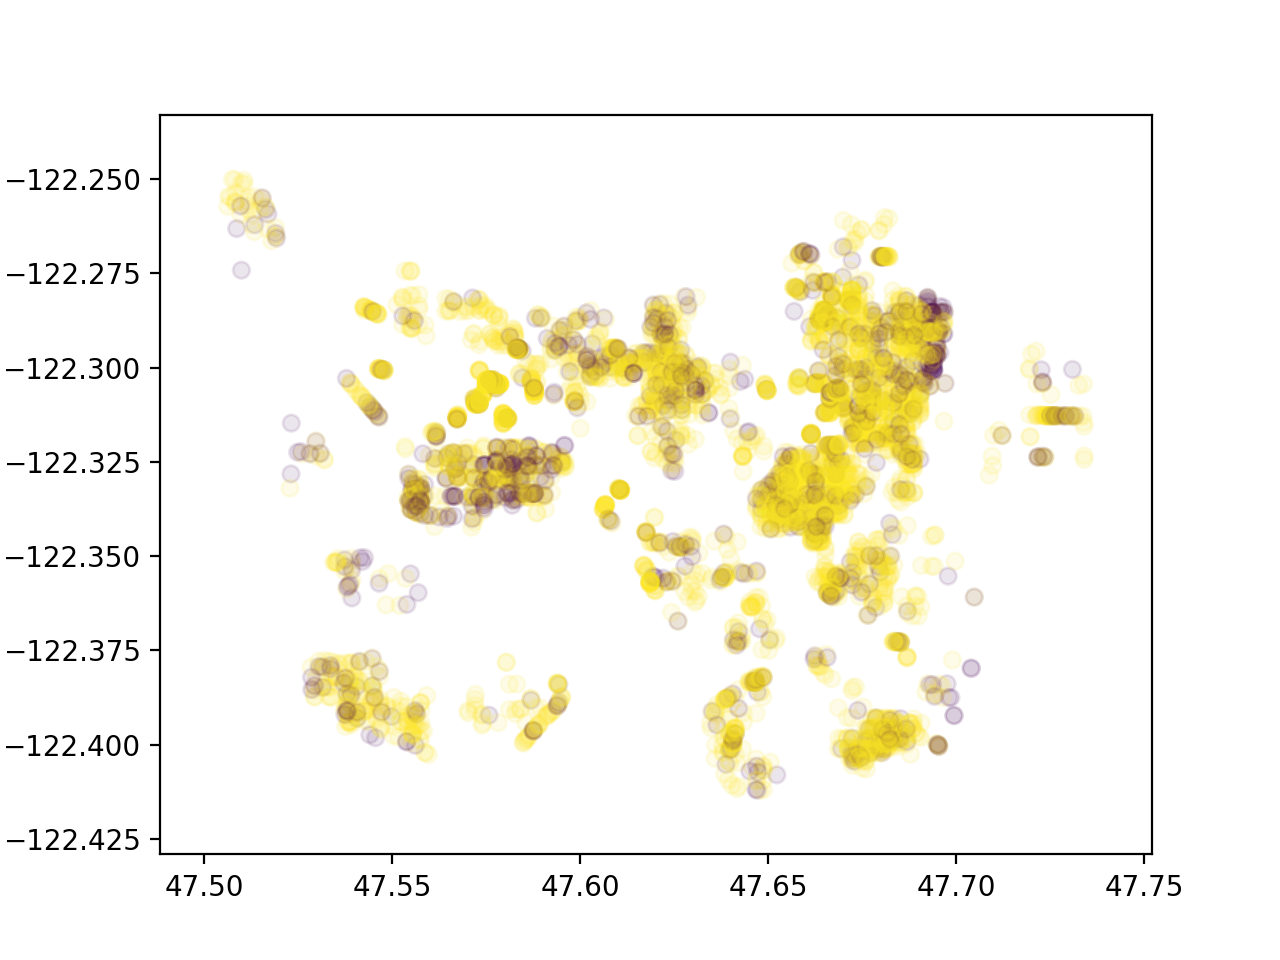

In [127]:
plt.figure()
plt.scatter(vals.lat, vals.lng, c=vals.correct, alpha=0.1)

In [574]:
X_train, X_test, y_train, y_test = train_test_split(vals[['lat', 'lng']], vals['correct'], test_size=0.2)

In [559]:
n_neighbors = 100

In [560]:
# neigh = KNeighborsClassifier(n_neighbors=n_neighbors)
# neigh = RandomForestClassifier(n_estimators=1000)
neigh = BaggingClassifier(n_jobs=-1, n_estimators=1000)
# neigh = DecisionTreeClassifier()
neigh.fit(X_train, y_train)
prediction = neigh.predict_proba(X_test)
# prediction = neigh.predict(X_test)

<IPython.core.display.Javascript object>


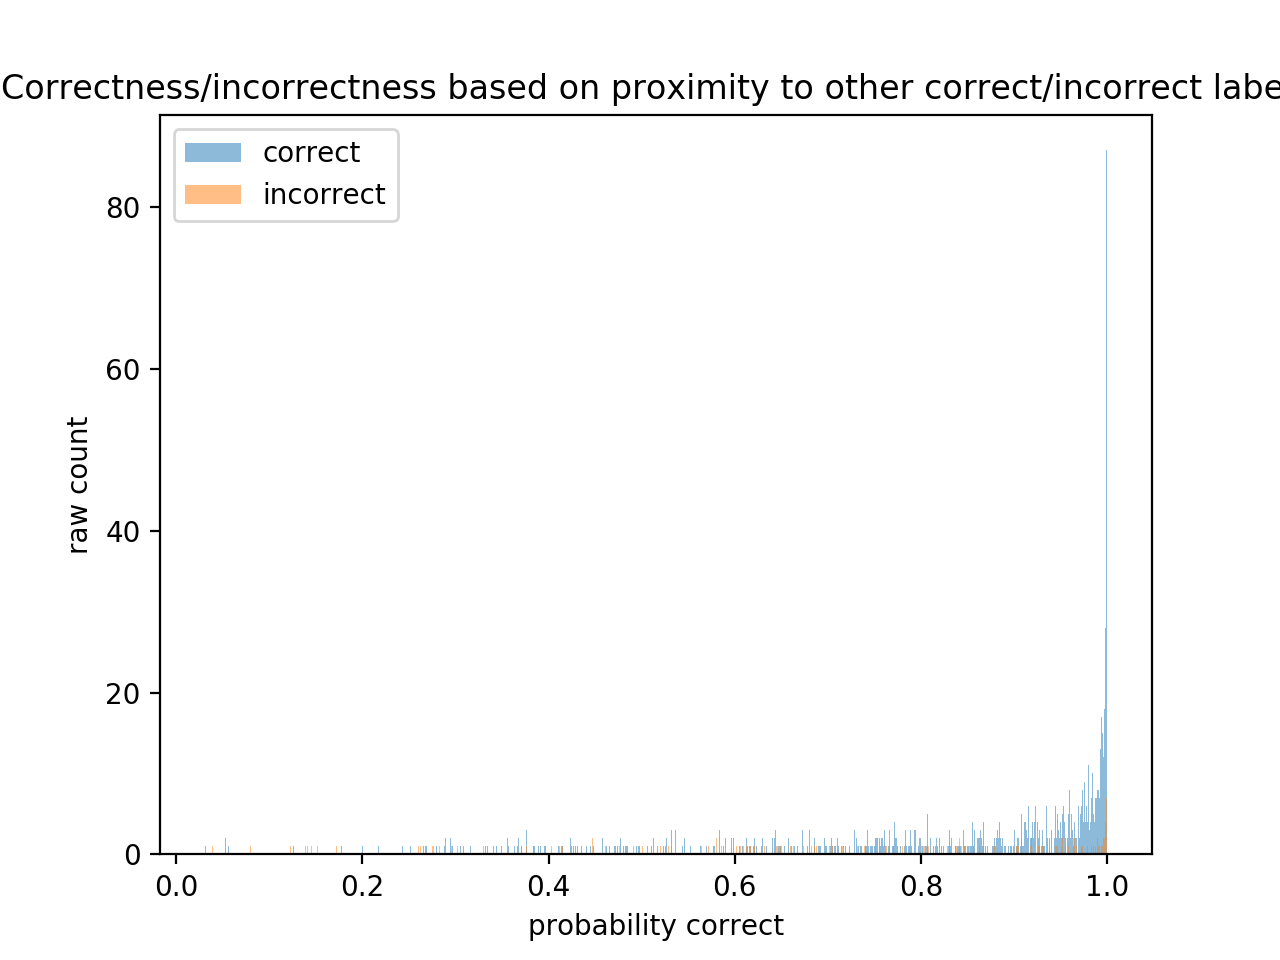

In [564]:
## plt.figure()
plt.title('Correctness/incorrectness based on proximity to other correct/incorrect labels')
plt.xlabel('probability correct')
plt.ylabel('raw count')
plt.hist(prediction[:, 1][y_test==1], bins=1000, alpha=0.5, label='correct')
plt.hist(prediction[:, 1][y_test==0], bins=1000, alpha=0.5, label='incorrect')
plt.legend()

In [573]:
mask = prediction[:, 1] == 1
print(np.sum(mask) / np.sum(y_test==1))
print(np.mean(y_test[mask]))

0.10307017543859649
0.925531914893617


In [45]:
X = vals[['lat', 'lng']].values
y = vals['correct'].values

In [46]:
from sklearn import neighbors

In [99]:
# for radius in np.arange(0.000001, 0.000020, 0.000001):

radius = 0.000015
prec_sum = 0
recall_sum = 0
for train_index, test_index in KFold(n_splits=5, shuffle=True, random_state=0).split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    neigh = BaggingClassifier(n_jobs=-1, n_estimators=1000)
#     neigh = neighbors.RadiusNeighborsClassifier(radius=radius, outlier_label=-1)
    neigh.fit(X_train, y_train)
    prediction = neigh.predict_proba(X_test)
#     prediction = neigh.predict(X_test)
#     mask = prediction[:] == 1
    mask = prediction[:, 1] == 1
    prec_sum += np.mean(y_test[mask])
    recall_sum += np.sum(y_test[mask]) / np.sum(y_test==1)

#     print(f'radius: {radius:.6f}')
print(f'precision: {(100 * (prec_sum / 5)):.2f}%')
print(f'recall: {(100 * (recall_sum / 5)):.2f}%')


precision: 93.78%
recall: 8.76%


In [124]:
radius = 0.000017
prec_sum = 0
recall_sum = 0
for train_index, test_index in KFold(n_splits=5, shuffle=True, random_state=0).split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
#     neigh = BaggingClassifier(n_jobs=-1, n_estimators=1000)
    neigh = neighbors.RadiusNeighborsClassifier(radius=radius, outlier_label=-1)
    neigh.fit(X_train, y_train)
#     prediction = neigh.predict_proba(X_test)
    prediction = neigh.predict(X_test)
    mask = prediction[:] == 1
#     mask = prediction[:, 1] == 1
    prec_sum += np.mean(y_test[mask])
    recall_sum += np.sum(y_test[mask]) / np.sum(y_test==1)

#     print(f'radius: {radius:.6f}')
print(f'precision: {(100 * (prec_sum / 5)):.2f}%')
print(f'recall: {(100 * (recall_sum / 5)):.2f}%')


precision: 93.44%
recall: 7.18%
